# A CNN architecture application for the recognition of parkinsonian magnified landmarks

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import * 
from keras.models import Sequential
from keras import optimizers 
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.utils import np_utils
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, BatchNormalization
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


### Data loading
- **controls.csv** contains the **magnified** average landmarks for control patients in **resting** position. 
- **parkinsonians.csv** contains the **magnified** average landmarks for parkinsonian patients in **resting** position.

Each average landmark was obtained from 10 finger landmarks of each video (see figure below). There are 4 video samples per each patient: 5 control and 5 parkinson, thus yielding 20 average landmarks for each class, i.e., 40 signals in total.  
<img src="landm.png" style="width:300px;height:250px;">  

In [29]:
names = [c for c in range(149)]
parkinsonians = pd.read_csv('parkinsonians.csv', names=names)
control = pd.read_csv('controls.csv', names=names)

### Data visualization 

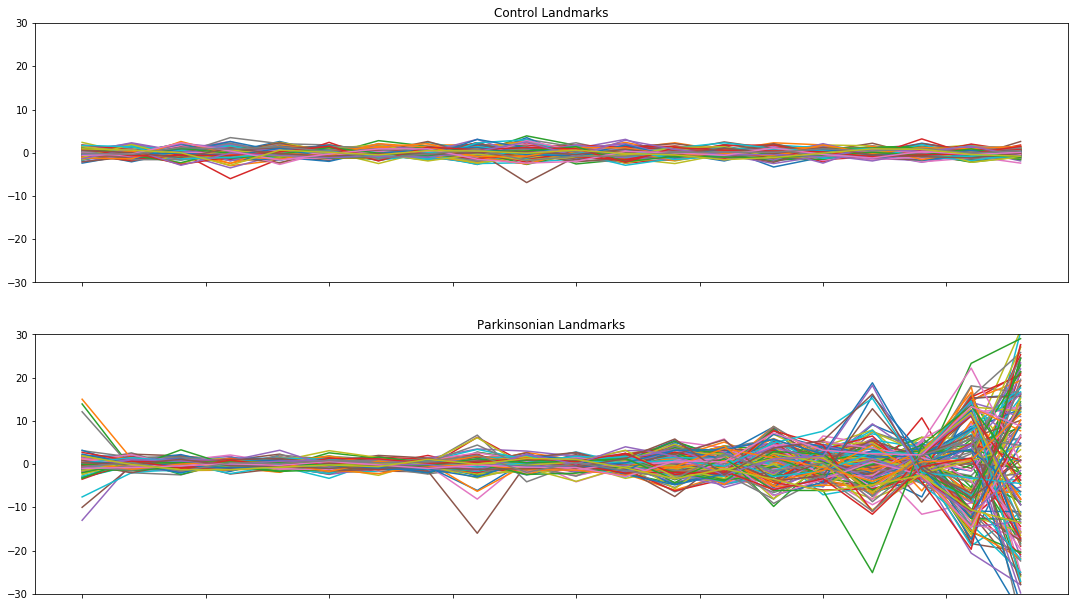

In [30]:
fig, axarr = plt.subplots(2, 1);
fig.set_size_inches(18.5, 10.5)
axarr[0].plot(control);
axarr[0].set_title('Control Landmarks');
axarr[1].plot(parkinsonians);
axarr[1].set_title('Parkinsonian Landmarks');
plt.setp(axarr[0].get_xticklabels(), visible=False);
plt.setp(axarr[1].get_xticklabels(), visible=False);
axarr[0].set_ylim([-30,30]);
axarr[1].set_ylim([-30,30]);

### Dataset creation
- 30 Landmarks of dimension 1x149 for training (15 Control, 15 Parkinson).  
- 10 Landmarks of dimension 1x149 for testing (5 Control, 5 Parkinson).  

Binary classification task: Parkinson VS Control

In [38]:
X_train_orig = pd.concat([parkinsonians.iloc[:-5,:],control.iloc[:-5,:]], axis=0).values
X_test_orig = pd.concat([parkinsonians.iloc[-5:,:],control.iloc[-5:,:]], axis=0).values
Y_train_orig = np.concatenate((np.ones(parkinsonians.iloc[:-5,:].shape[0]),np.zeros(control.iloc[:-5,:].shape[0])), axis=None)
Y_test_orig = np.concatenate((np.ones(parkinsonians.iloc[-5:,:].shape[0]),np.zeros(control.iloc[-5:,:].shape[0])), axis=None)
classes = np.array([1,0])

In [39]:
X_train = X_train_orig
X_test = X_test_orig
Y_train = Y_train_orig
Y_test = Y_test_orig
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 30
number of test examples = 10
X_train shape: (30, 149)
Y_train shape: (30,)
X_test shape: (10, 149)
Y_test shape: (10,)


### Proposed CNN architecture:  
<img src="arqok.png">  

**Description:**
1-D Convolutional model 
- **a. CONV 100:** First convolutional layer with 100 filters of dimension 1x8, weight initialization through Gaussian distribution, and Relu activation function.
- **b. MAX-POOL:** Max pooling with a 1x6 window, step=1, no padding.
- **c. CONV 50:** Second convolutional layer with 50 filters of dimension 1x4x100, weight initialization through *he_normal* method [1], and hyperbolic tangent activation function.
- **d. MAX-POOL:** Max pooling with a 1x3 window, step=1, no padding.
- **e. CONV 30:** Third convolutional layer with 30 filters of dimension 1x2x50, weight initialization through *he_normal* method [1], and hyperbolic tangent activation function.
- **f. MAX-POOL:** Max pooling with a 1x10 window, step=1, no padding.
- **g. FC 100:** Fully connected layer with 100 neurons and Relu activation function. Dropout of 0.4 to avoid model over-training due to little data.
- **h. Out:** Single neuron output layer with sigmoid activation since it's a binary problem.  

Adam optimization algorithm, binary entropy loss function and accuracy evaluation metric. Training in 500 epochs, batch size of 16.

[1] He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.

In [40]:
def model(X_train,y_train,X_test,y_test):
    input_shape = (X_train.shape[1], 1)
    model = Sequential(name='1Convnet')
    
    model.add(Conv1D(filters = 100, kernel_size = 8, kernel_initializer='normal',activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=6, strides=1, padding='valid'))
    
    model.add(Conv1D(filters = 50, kernel_size = 4, kernel_initializer=he_normal(seed=0),activation='tanh'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))
    
    model.add(Conv1D(filters = 30, kernel_size = 2,kernel_initializer=he_normal(seed=0),activation='tanh'))
    model.add(MaxPooling1D(pool_size=10, strides=1, padding='valid'))
    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    
    adam = optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    print(model.summary())
    model.fit(X_train, y_train, epochs=500,validation_data=(X_test, y_test), batch_size=16)
    return model

In [41]:
def prepo_data(X_train,X_test,Y_train,Y_test):
    X_train_r =  np.expand_dims(X_train, axis=2)
    X_test_r = np.expand_dims(X_test, axis=2)
    # labels (train and test)
    y_train = Y_train.reshape((Y_train.shape[0],1))
    y_test = Y_test.reshape((Y_test.shape[0],1))
    return X_train_r, y_train, X_test_r , y_test

X_train, y_train, X_test, y_test = prepo_data(X_train, X_test, Y_train, Y_test)

In [42]:
model(X_train, Y_train, X_test, Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 142, 100)          900       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 137, 100)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 134, 50)           20050     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 132, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 131, 30)           3030      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 122, 30)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3660)              0         
__________

30/30 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.7590 - val_acc: 0.8000
Epoch 51/500
30/30 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.7582 - val_acc: 0.8000
Epoch 52/500
30/30 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.7567 - val_acc: 0.8000
Epoch 53/500
30/30 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.7509 - val_acc: 0.8000
Epoch 54/500
30/30 [==============================] - 0s 2ms/step - loss: 7.2867e-04 - acc: 1.0000 - val_loss: 0.7431 - val_acc: 0.8000
Epoch 55/500
30/30 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.7360 - val_acc: 0.8000
Epoch 56/500
30/30 [==============================] - 0s 2ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.7327 - val_acc: 0.8000
Epoch 57/500
30/30 [==============================] - 0s 2ms/step - loss: 0.0018 - ac

Epoch 111/500
30/30 [==============================] - 0s 2ms/step - loss: 2.6686e-04 - acc: 1.0000 - val_loss: 0.8184 - val_acc: 0.8000
Epoch 112/500
30/30 [==============================] - 0s 2ms/step - loss: 2.8146e-04 - acc: 1.0000 - val_loss: 0.8203 - val_acc: 0.8000
Epoch 113/500
30/30 [==============================] - 0s 2ms/step - loss: 3.3679e-04 - acc: 1.0000 - val_loss: 0.8226 - val_acc: 0.8000
Epoch 114/500
30/30 [==============================] - 0s 2ms/step - loss: 2.6229e-04 - acc: 1.0000 - val_loss: 0.8255 - val_acc: 0.8000
Epoch 115/500
30/30 [==============================] - 0s 2ms/step - loss: 3.6449e-04 - acc: 1.0000 - val_loss: 0.8279 - val_acc: 0.8000
Epoch 116/500
30/30 [==============================] - 0s 2ms/step - loss: 2.7996e-04 - acc: 1.0000 - val_loss: 0.8297 - val_acc: 0.8000
Epoch 117/500
30/30 [==============================] - 0s 2ms/step - loss: 2.8932e-04 - acc: 1.0000 - val_loss: 0.8317 - val_acc: 0.8000
Epoch 118/500
30/30 [====================

Epoch 171/500
30/30 [==============================] - 0s 2ms/step - loss: 2.3001e-04 - acc: 1.0000 - val_loss: 0.8535 - val_acc: 0.8000
Epoch 172/500
30/30 [==============================] - 0s 2ms/step - loss: 2.9280e-04 - acc: 1.0000 - val_loss: 0.8540 - val_acc: 0.8000
Epoch 173/500
30/30 [==============================] - 0s 2ms/step - loss: 2.5256e-04 - acc: 1.0000 - val_loss: 0.8545 - val_acc: 0.8000
Epoch 174/500
30/30 [==============================] - 0s 2ms/step - loss: 2.7438e-04 - acc: 1.0000 - val_loss: 0.8548 - val_acc: 0.8000
Epoch 175/500
30/30 [==============================] - 0s 2ms/step - loss: 1.4233e-04 - acc: 1.0000 - val_loss: 0.8554 - val_acc: 0.8000
Epoch 176/500
30/30 [==============================] - 0s 2ms/step - loss: 7.8351e-05 - acc: 1.0000 - val_loss: 0.8560 - val_acc: 0.8000
Epoch 177/500
30/30 [==============================] - 0s 2ms/step - loss: 3.7275e-04 - acc: 1.0000 - val_loss: 0.8568 - val_acc: 0.8000
Epoch 178/500
30/30 [====================

Epoch 231/500
30/30 [==============================] - 0s 2ms/step - loss: 1.1382e-04 - acc: 1.0000 - val_loss: 0.8757 - val_acc: 0.8000
Epoch 232/500
30/30 [==============================] - 0s 2ms/step - loss: 6.3874e-05 - acc: 1.0000 - val_loss: 0.8763 - val_acc: 0.8000
Epoch 233/500
30/30 [==============================] - 0s 2ms/step - loss: 8.2661e-05 - acc: 1.0000 - val_loss: 0.8768 - val_acc: 0.8000
Epoch 234/500
30/30 [==============================] - 0s 2ms/step - loss: 6.6820e-05 - acc: 1.0000 - val_loss: 0.8769 - val_acc: 0.8000
Epoch 235/500
30/30 [==============================] - 0s 2ms/step - loss: 4.6755e-05 - acc: 1.0000 - val_loss: 0.8771 - val_acc: 0.8000
Epoch 236/500
30/30 [==============================] - 0s 2ms/step - loss: 9.9719e-05 - acc: 1.0000 - val_loss: 0.8772 - val_acc: 0.8000
Epoch 237/500
30/30 [==============================] - 0s 2ms/step - loss: 6.0722e-05 - acc: 1.0000 - val_loss: 0.8773 - val_acc: 0.8000
Epoch 238/500
30/30 [====================

Epoch 291/500
30/30 [==============================] - 0s 2ms/step - loss: 6.5703e-05 - acc: 1.0000 - val_loss: 0.9133 - val_acc: 0.8000
Epoch 292/500
30/30 [==============================] - 0s 2ms/step - loss: 1.5234e-04 - acc: 1.0000 - val_loss: 0.9131 - val_acc: 0.8000
Epoch 293/500
30/30 [==============================] - 0s 2ms/step - loss: 3.3662e-05 - acc: 1.0000 - val_loss: 0.9130 - val_acc: 0.8000
Epoch 294/500
30/30 [==============================] - 0s 2ms/step - loss: 1.4837e-04 - acc: 1.0000 - val_loss: 0.9134 - val_acc: 0.8000
Epoch 295/500
30/30 [==============================] - 0s 2ms/step - loss: 4.6793e-05 - acc: 1.0000 - val_loss: 0.9142 - val_acc: 0.8000
Epoch 296/500
30/30 [==============================] - 0s 2ms/step - loss: 3.4141e-05 - acc: 1.0000 - val_loss: 0.9151 - val_acc: 0.8000
Epoch 297/500
30/30 [==============================] - 0s 2ms/step - loss: 2.8271e-04 - acc: 1.0000 - val_loss: 0.9170 - val_acc: 0.8000
Epoch 298/500
30/30 [====================

Epoch 351/500
30/30 [==============================] - 0s 2ms/step - loss: 2.7513e-05 - acc: 1.0000 - val_loss: 0.9265 - val_acc: 0.8000
Epoch 352/500
30/30 [==============================] - 0s 2ms/step - loss: 1.4862e-04 - acc: 1.0000 - val_loss: 0.9278 - val_acc: 0.8000
Epoch 353/500
30/30 [==============================] - 0s 2ms/step - loss: 1.9962e-05 - acc: 1.0000 - val_loss: 0.9300 - val_acc: 0.8000
Epoch 354/500
30/30 [==============================] - 0s 2ms/step - loss: 8.9068e-05 - acc: 1.0000 - val_loss: 0.9309 - val_acc: 0.8000
Epoch 355/500
30/30 [==============================] - 0s 2ms/step - loss: 4.3266e-05 - acc: 1.0000 - val_loss: 0.9315 - val_acc: 0.8000
Epoch 356/500
30/30 [==============================] - 0s 2ms/step - loss: 1.0829e-04 - acc: 1.0000 - val_loss: 0.9313 - val_acc: 0.8000
Epoch 357/500
30/30 [==============================] - 0s 2ms/step - loss: 3.8563e-05 - acc: 1.0000 - val_loss: 0.9311 - val_acc: 0.8000
Epoch 358/500
30/30 [====================

Epoch 411/500
30/30 [==============================] - 0s 2ms/step - loss: 7.1963e-05 - acc: 1.0000 - val_loss: 0.9262 - val_acc: 0.8000
Epoch 412/500
30/30 [==============================] - 0s 1ms/step - loss: 3.6661e-05 - acc: 1.0000 - val_loss: 0.9244 - val_acc: 0.8000
Epoch 413/500
30/30 [==============================] - 0s 2ms/step - loss: 4.2316e-05 - acc: 1.0000 - val_loss: 0.9230 - val_acc: 0.8000
Epoch 414/500
30/30 [==============================] - 0s 2ms/step - loss: 1.3901e-04 - acc: 1.0000 - val_loss: 0.9222 - val_acc: 0.8000
Epoch 415/500
30/30 [==============================] - 0s 2ms/step - loss: 3.0592e-05 - acc: 1.0000 - val_loss: 0.9234 - val_acc: 0.8000
Epoch 416/500
30/30 [==============================] - 0s 1ms/step - loss: 5.4887e-05 - acc: 1.0000 - val_loss: 0.9252 - val_acc: 0.8000
Epoch 417/500
30/30 [==============================] - 0s 2ms/step - loss: 6.3873e-05 - acc: 1.0000 - val_loss: 0.9275 - val_acc: 0.8000
Epoch 418/500
30/30 [====================

Epoch 471/500
30/30 [==============================] - 0s 2ms/step - loss: 4.7554e-05 - acc: 1.0000 - val_loss: 0.9540 - val_acc: 0.8000
Epoch 472/500
30/30 [==============================] - 0s 1ms/step - loss: 5.1223e-05 - acc: 1.0000 - val_loss: 0.9546 - val_acc: 0.8000
Epoch 473/500
30/30 [==============================] - 0s 1ms/step - loss: 1.5398e-05 - acc: 1.0000 - val_loss: 0.9554 - val_acc: 0.8000
Epoch 474/500
30/30 [==============================] - 0s 1ms/step - loss: 1.5816e-05 - acc: 1.0000 - val_loss: 0.9563 - val_acc: 0.8000
Epoch 475/500
30/30 [==============================] - 0s 2ms/step - loss: 4.8602e-05 - acc: 1.0000 - val_loss: 0.9573 - val_acc: 0.8000
Epoch 476/500
30/30 [==============================] - 0s 1ms/step - loss: 3.5923e-05 - acc: 1.0000 - val_loss: 0.9583 - val_acc: 0.8000
Epoch 477/500
30/30 [==============================] - 0s 2ms/step - loss: 2.8929e-05 - acc: 1.0000 - val_loss: 0.9596 - val_acc: 0.8000
Epoch 478/500
30/30 [====================

### Conclusions:
<br>
<font size="3">
100% of accuracy was obtained in the training set and 80% in the test set. The model can be improved as follows: <br>
- 1. Acquiring more data. <br>
- 2. Applying more regularization. <br>
- 3. Modifying the optimization algorithm. <br>
- 4. Making wise changes in the architecture. 
</font>